# Introduction to Athena
## Modelling the Effect of Relative Humidity on Surface Temperature

In this short tutorial, we'll use Athena to build an equation that models the relationship between hour of day, humidity, and surface temperature. The data is from a hobbyist weather station that is owned by ArabiaWeather.

In [1]:
import pandas as pd
from dateutil.parser import parse 

from athena.equations import *
from athena.framework import Framework
from athena.dataset import Dataset
from athena.model import AdditiveModel
from athena.helpers import *

Fix the random seed so that we can obtain reproducible results.

In [2]:
np.random.seed(seed = 4)

## Importing Data and Data Sanitization 

We read in our data from a comma separated values (CSV) file using the Pandas library. We are only interested in a select few columns in the data so we select only them.

In [3]:
data_frame = pd.read_csv('/home/khaled/repositories/athena-github/ivzhe139.csv')
data_frame = data_frame[["time", "temp", "humidity"]]

We have to sanitize the data before we start fitting equations to it. We need a function to convert time to a percentage of the day (eg: 12:00 would become 50%). This will help a great deal when we want to fit a sine wave to the hour of day to relate it to surface temperature.

In [4]:
def get_hour(x):
    y = parse(x)
    return y.hour + y.minute/60.0

data_frame["time"] = [get_hour(x)/24.0 for x in data_frame["time"].values]

Athena includes some helper functions to assist in equation building; one of them is the `split_dataframe` function. This will randomly split the data into `x%` training and `(100-x)%` testing sets.

In [5]:
training_df, testing_df = split_dataframe(data_frame, 0.9)

Athena can also automatically normalize your data; normalizing data to fit between 0 and 1 greatly assists curve fitting because most of the built in equations are designed to work optimally on that numerical range. A parameter map first splits columns into normalized and non-normalized, then maps each column name in the data to a short-hand name to be used in the equation. Here we will map `time` to `t`, and `humidity` to `h`.

In [6]:
parameters_map = {
    "normalized": {
        
    },
    "not_normalized": {
        "time": "t",
        "humidity": "h",     
    }
}

## Using the Athena Framework

Every equation building session in Athena operates out of something called a `Framework`; as its name suggests, an Athena framework will consilidate all your datasets, equations, hyper-parameters, etc in one Python class. Beginning a `Framework` class requires passing a Python dictionary containing hyper-parameters; you can leave this empty and the default parameters will be used instead.

In [34]:
max_iterations = int(1e4)
starter_learning_rate = 0.0005
momentum = 0.95

framework_parameters = {
    "starting_lr": starter_learning_rate,
    "max_iterations": max_iterations,
    "momentum": momentum,
}

fw = Framework(framework_parameters)

We can initialize our datasets along with their parameter map using the `Dataset` class. We then feed this into the `Framework` class by using the function `add_dataset`. Our data is now sanitized and inside our framework, ready for processing and equation building.

In [ ]:
fw.add_dataset(Dataset(parameters_map, training_df, testing_df))

## Introduction to the Additive Model

There are many types of model equations we can use through Athena as a base for our equation building blocks. The simplest of which is the Additive Model; this means that every function in this model is added - for example, if we have `f(a)`, `g(b)`, and `h(c)`, applying these to an additive model will create an equation of the form `f(a) + g(b) + h(c)`. There are more complex models available to the user, such as the multiplicative model and the composite model, all of which are explained in more advanced tutorials.

In [35]:
model = AdditiveModel(fw)

We get the target column in both training and testing datasets and assign them as floats in `training_targets` and `testing_targets` to be used later in accuracy measurement.

In [36]:
target_column_name = "temp"
training_targets = training_df[target_column_name].values.astype(np.float32)
testing_targets = testing_df[target_column_name].values.astype(np.float32)

Creating the components of an additive model is simple and similar in fashion to creating a neural network model in Keras, for example. We first add a `Bias` function, the simplest kind of function which adds a variable number to our equation. Then we add four `SimpleSinusoidal` functions and pass them the name of the column we want the function to work on; since temperature changes sinusoidally with time, we add four sine functions that have variable amplitudes, frequencies, and phase shifts to our equation (thisis very similar to taking the first four terms in an [infintie Fourier series](https://en.wikipedia.org/wiki/Fourier_series)). Finally, because we assume that humidity changes exponentially with temperature, we add two `FlexiblePower` functions to reflect this assumption.

In [37]:
model.add(Bias)

for i in range(4):
    model.add(SimpleSinusoidal, "time")

for i in range(2):
    model.add(FlexiblePower, "humidity")


fw.initialize(model, training_targets)

Here comes the fun part: iteratively fitting our equation. Athena, using Tensorflow as its backend, will automatically differentiate the equation we want to fit our data to, then find the roots of the differential using whichever optimization algorithm we specified in the framework (the default algorithm is the [Adam Stochastic Optimization](https://arxiv.org/abs/1412.6980) algorithm). At every 10% of the fitting process, we output some accuracy metrics of our equation for both the training and testing datasets; in this example, we output the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), then the root mean squared error, 90th, 95th and 99th percentile errors, in that order.

In [38]:
for step in range(int(fw.max_iters + 1)):
    fw.run_learning_step()
    if step % int(fw.max_iters / 10) == 0:
        print("\n", "=" * 40, "\n", round(step / fw.max_iters * 100), "% \n", "=" * 40, sep="", end="\n")
        training_t = training_targets, fw.get_training_predictions()
        testing_t = testing_targets, fw.get_testing_predictions()

        try:
            for j, k in list(zip(["Training", "Testing "], [training_t, testing_t])):
                print(j, end = "\t")
                print_statistics(*k)

        except Exception as e:
            print("Error! {}".format(e))


0% 
Training	-71.0	12.0	20.0	22.0	24.0
Testing 	-73.0	12.0	20.0	22.0	24.0

10% 
Training	80.0	2.0	4.0	5.0	7.0
Testing 	80.0	2.0	4.0	5.0	8.0

20% 
Training	83.0	2.0	4.0	4.0	6.0
Testing 	83.0	2.0	4.0	4.0	7.0

30% 
Training	85.0	2.0	4.0	4.0	6.0
Testing 	85.0	2.0	3.0	4.0	7.0

40% 
Training	86.0	2.0	3.0	4.0	6.0
Testing 	85.0	2.0	3.0	4.0	6.0

50% 
Training	86.0	2.0	3.0	4.0	6.0
Testing 	86.0	2.0	3.0	4.0	6.0

60% 
Training	86.0	2.0	3.0	4.0	6.0
Testing 	86.0	2.0	3.0	4.0	6.0

70% 
Training	86.0	2.0	3.0	4.0	6.0
Testing 	86.0	2.0	3.0	4.0	6.0

80% 
Training	86.0	2.0	3.0	4.0	6.0
Testing 	86.0	2.0	3.0	4.0	6.0

90% 
Training	86.0	2.0	3.0	4.0	6.0
Testing 	86.0	2.0	3.0	4.0	6.0

100% 
Training	86.0	2.0	3.0	4.0	6.0
Testing 	86.0	2.0	3.0	4.0	6.0


We can get the equation from Athena by using the framework function `produce_equation`. This will return a `sympy` equation; `sympy` is, at its core, a [powerful Python library for symbolic mathematics](http://docs.sympy.org/latest/index.html) - we will need it for a bunch of cool things, like automatic symbolic simplification, pretty printing, and even outputting LaTeX for use in an academic paper.

In [39]:
equation = fw.produce_equation()
fw.session.close()

## Visualizing the Result with Sympy and Matplotlib

When in an interactive Python notebook, we can output a pretty simplified version of our temperature equation to the notebook and examine the coefficients we produced. Upon simple inspection, we can see we inferred an inverse correlation, also known as a negative correlation, between humidity and temperature. That is, the more we increase humidity, we will see an exponential decrease in temperature.

In [40]:
from sympy import pprint, N, nsimplify, init_printing

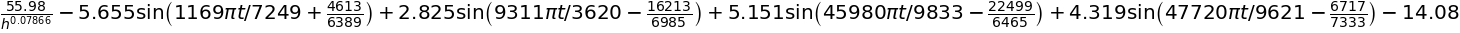

In [41]:
init_printing()
N(nsimplify(equation, tolerance=1e-4), 4)

In [42]:
% pylab inline
import seaborn as sns
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [43]:
from sympy import lambdify
from sympy.abc import t, h

`Sympy` lets us create a fast Python function from our generated equation, so that we can quickly substitute large arrays of numbers to produce results for table or chart production later.

In [44]:
y_axis = lambdify((t, h), equation, "numpy")

Let's observe the effect of increasing humidity on surface temperature throughout the hours of the day. We can generate the y-axis for each humidity level by utilizing the function we created before. We'll plot the temperatures at varying humidity levels on the same graph.

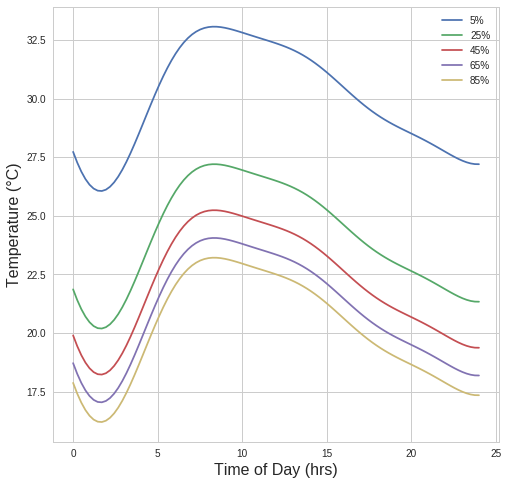

In [48]:
plt.figure(figsize=(8, 8))
x_axis = np.linspace(0.0, 1.0, 100)

for humidity in range(5, 100 + 1, 20):
    plt.plot(x_axis * 24.0, y_axis(x_axis, np.array([humidity])), label='{}%'.format(humidity))

plt.legend()
plt.xlabel('Time of Day (hrs)', fontsize=16)
plt.ylabel('Temperature (°C)', fontsize=16)
plt.show()